# IoT Network Intrusion Detection with Privacy-Preserving Federated Learning

## Project Overview
This Kaggle notebook implements a scalable Intrusion Detection System (IDS) for IoT networks using the CICIoT2023 dataset. The system classifies 33 types of IoT attacks (e.g., DDoS, MITM) from network flows while incorporating privacy-preserving federated learning to simulate training across distributed devices without sharing raw data.

### Objectives
- Build a hybrid CNN-LSTM model for sequence-based attack classification.
- Handle extreme class imbalance and high-dimensional features (80+ per flow).
- Simulate federated learning using the Flower library to mimic real-world IoT privacy constraints.
- Evaluate the model on unseen attacks and deploy a real-time inference simulation.
- Incorporate explainability with SHAP and LIME for ethical AI practices.

### Dataset
- **Source**: [CICIoT2023 on Kaggle](https://www.kaggle.com/datasets/madhavmalhotra/unb-cic-iot-dataset) (8.42 GB, 63 CSV files).
- **Usage**: We will sample 20% of the dataset for efficiency while maintaining the "real deal" scale, processed with Dask for big data handling.
- **Key Stats**:
  | Aspect | Details |
  |--------|---------|
  | Size | 8.42 GB |
  | Files | 63 CSVs |
  | Features | 80+ per flow (e.g., packet sizes, protocols) |
  | Classes | 34 (33 attacks + normal) |
  | Imbalance | Normal traffic ~80% |

### Why Complex & Unique?
- Extreme imbalance and high dimensionality require advanced techniques like SMOTE/ADASYN.
- Federated setup differentiates from standard classifiers by enforcing privacy.
- Showcases skills: Big data (Dask), DL optimization (CNN-LSTM), Federated Learning (Flower), Explainability (SHAP/LIME).

### Tech Stack & Skills Showcased
- **Big Data**: Dask for distributed processing.
- **Imbalance Handling**: SMOTE from imbalanced-learn.
- **Model**: Hybrid CNN-LSTM in TensorFlow/Keras.
- **Federated Learning**: Flower for simulation.
- **Explainability**: SHAP and LIME.
- **Optimization**: Early stopping, mixed precision for DL efficiency.
- **Ethical AI**: Privacy focus in federated setup.

**Note**: Run this notebook on Kaggle with GPU accelerator enabled. Monitor memory with `!free -h` and use checkpoints.

## Setup Instructions
1. Add the CICIoT2023 dataset to this notebook via Kaggle's "Add Data" (path: `/kaggle/input/ciciot2023`).
2. Enable GPU accelerator: Notebook options > Accelerator > GPU P100.
3. Install dependencies in the next cell.
4. Expected Runtime: 2-4 hours (depending on federated rounds).

# Code

## Dependencies

In [1]:
!pip install --no-deps imbalanced-learn==0.12.0
import os, gc, random, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
SEED = 42
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

print("Environment ready | Seed =", SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
Environment ready | Seed = 42


## Imports
Import all necessary libraries. We use TensorFlow for the model, Dask for data handling, and Flower for federated learning.

In [2]:
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, BatchNormalization,
    LSTM, Dropout, Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.mixed_precision import set_global_policy

import joblib
import optuna, shap, gc, time

# enable mixed precision if GPU exists
if len(tf.config.list_physical_devices('GPU')) > 0:
    set_global_policy("mixed_float16")
    print("Mixed precision enabled")


E0000 00:00:1765691814.915179      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765691814.967160      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Mixed precision enabled


## Data Loading and Exploration
Load the dataset using Dask for efficient handling of large files. Sample 20% to maintain scale while fitting within Kaggle limits. Perform EDA to understand class distribution and features.

In [3]:
# %% [code]
# CELL 3 — LOAD DATA (DASK)
DATA_PATH = "/kaggle/input/labeled-ciciot-2023-dataset"

print("Loading CSVs with Dask...")
ddf = dd.read_csv(f"{DATA_PATH}/*.csv", assume_missing=True, dtype=str)

def safe_convert(df):
    for col in df.columns:
        if col.lower() != "label":
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

ddf = ddf.map_partitions(safe_convert)
ddf = ddf.sample(frac=0.20, random_state=SEED)  # 20% sample

with ProgressBar():
    df = ddf.compute()

print("Loaded:", df.shape)


Loading CSVs with Dask...
[########################################] | 100% Completed | 14m 16s
Loaded: (8147342, 40)


## Data Preprocessing
Clean data, encode labels, scale features, and split into train/test sets. Hold out certain attacks for unseen evaluation to simulate real-world scenarios.

In [4]:
# CLEAN + IMPUTE
label_cols = [c for c in df.columns if c.lower() == "label"]
if not label_cols:
    raise ValueError("Label column not found!")

LABEL_COL = label_cols[0]
print("Label column:", LABEL_COL)

num_cols = [c for c in df.columns if c != LABEL_COL]

# Convert to numeric cols only
numeric_cols = df[num_cols].select_dtypes(include=[np.number]).columns.tolist()

# median imputation
for col in numeric_cols:
    med = df[col].median()
    df[col].fillna(med, inplace=True)

print("After imputation:", df.shape)


Label column: Label
After imputation: (8147342, 40)


### EDA: Class Distribution,Basic Stats + Feature Overview,Correlation Heatmap (10 random features)

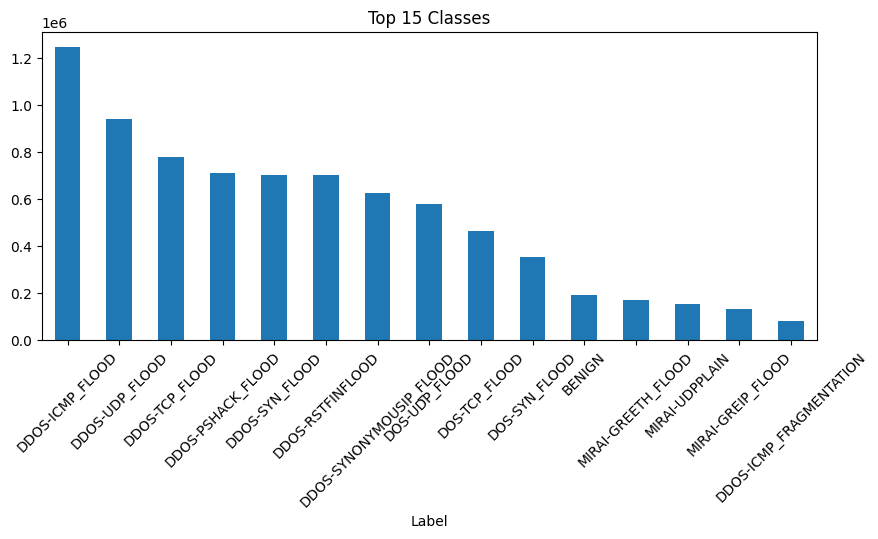

Label
DDOS-ICMP_FLOOD      1247349
DDOS-UDP_FLOOD        938368
DDOS-TCP_FLOOD        779735
DDOS-PSHACK_FLOOD     710031
DDOS-SYN_FLOOD        703230
Name: count, dtype: int64[pyarrow]
Number of samples: 8147342
Number of numeric features: 39

Summary Statistics (first 10 features):


,count,mean,std,min,25%,50%,75%,max
Header_Length,8147342.0,13.735234,8.722515,0.0,8.0,20.0,20.0,60.0
Protocol Type,8147342.0,9.091843,9.091933,0.0,6.0,6.0,17.0,47.0
Time_To_Live,8147342.0,66.530397,14.417457,0.0,64.0,64.0,64.0,255.0
Rate,8147342.0,inf,<NA>,0.000013,11386.735442,24600.02346,37950.63337,inf
fin_flag_number,8147342.0,0.086847,0.279232,0.0,0.0,0.0,0.0,1.0
syn_flag_number,8147342.0,0.206404,0.399445,0.0,0.0,0.0,0.01,1.0
rst_flag_number,8147342.0,0.092835,0.283192,0.0,0.0,0.0,0.0,1.0
psh_flag_number,8147342.0,0.093917,0.277057,0.0,0.0,0.0,0.0,1.0
ack_flag_number,8147342.0,0.129815,0.316632,0.0,0.0,0.0,0.01,1.0
ece_flag_number,8147342.0,0.000028,0.002009,0.0,0.0,0.0,0.0,1.0


Top features with missing values after inf cleanup:


Rate               194
Protocol Type        0
Header_Length        0
Time_To_Live         0
fin_flag_number      0
syn_flag_number      0
rst_flag_number      0
psh_flag_number      0
ack_flag_number      0
ece_flag_number      0
dtype: int64

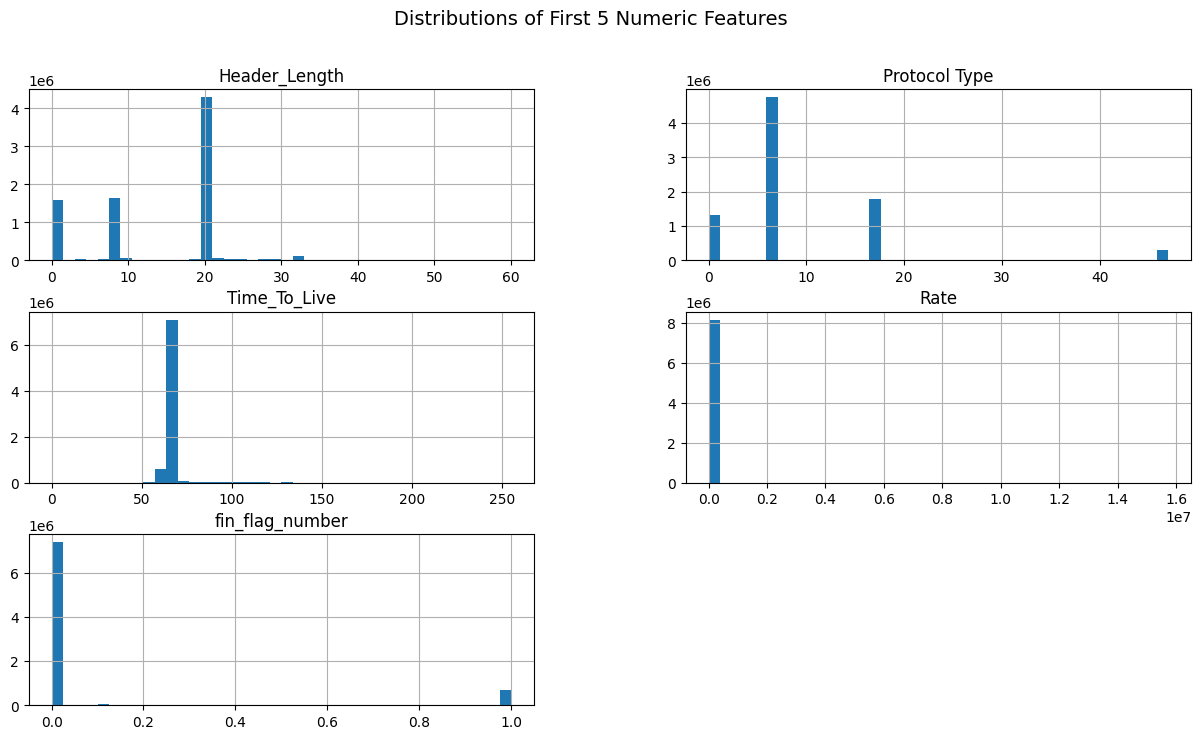

<Figure size 1200x400 with 0 Axes>

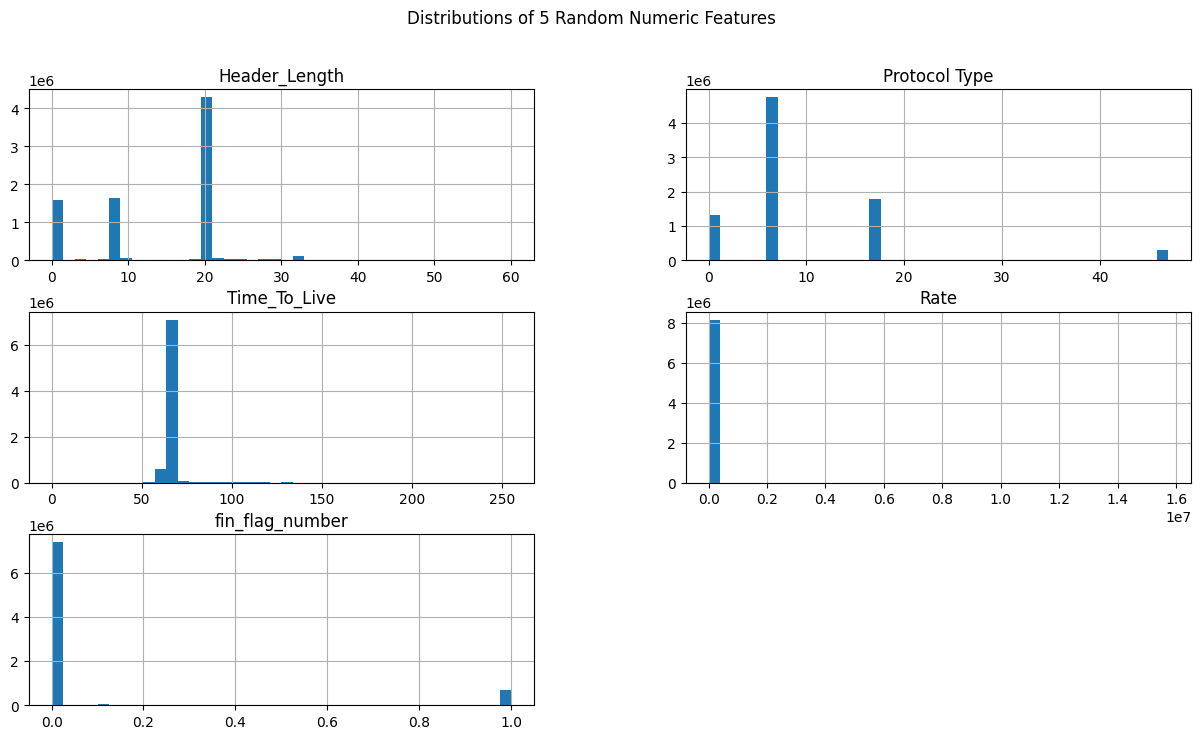

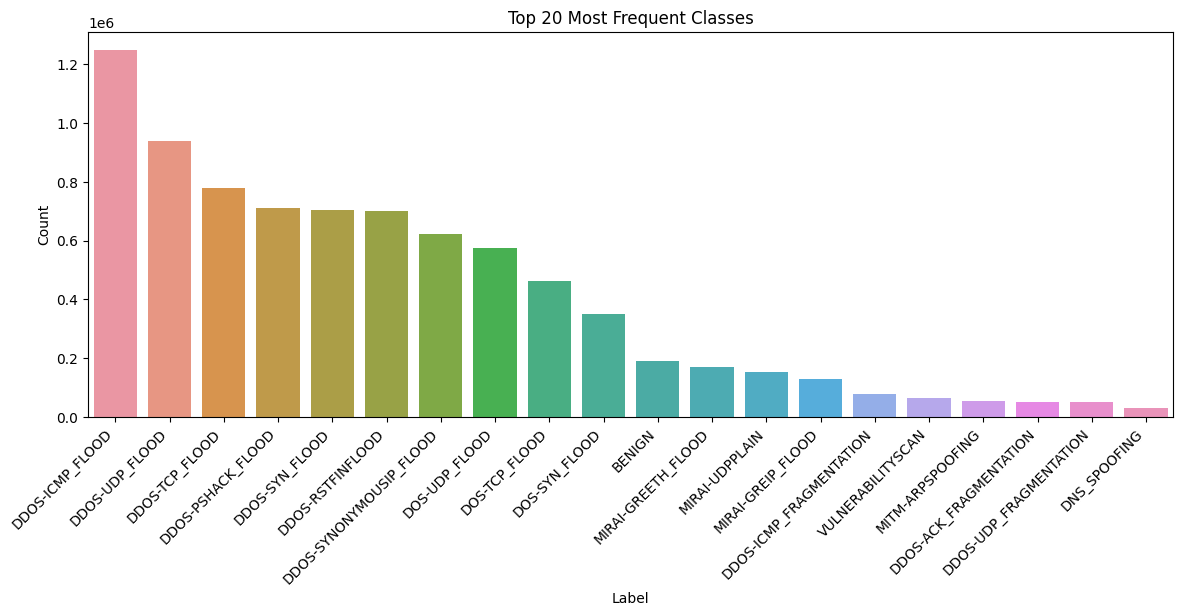

In [5]:
plt.figure(figsize=(10,4))
df[LABEL_COL].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Classes")
plt.xticks(rotation=45)
plt.show()

print(df[LABEL_COL].value_counts().head())

print("Number of samples:", len(df))
print("Number of numeric features:", len(numeric_cols))
print("\nSummary Statistics (first 10 features):")
display(df[numeric_cols].describe().T.head(10))

# Missing values
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Quick check
print("Top features with missing values after inf cleanup:")
display(df[numeric_cols].isna().sum().sort_values(ascending=False).head(10))

# Distribution check (first 5 numeric features)
df[numeric_cols].iloc[:, :5].hist(bins=40, figsize=(15,8))
plt.suptitle("Distributions of First 5 Numeric Features", fontsize=14)
plt.show()

# Basic distribution check
plt.figure(figsize=(12,4))
df[numeric_cols].iloc[:, :5].hist(bins=40, figsize=(15,8))
plt.suptitle("Distributions of 5 Random Numeric Features")
plt.show()

# %% [code]
# CELL 5.3 — CLASS IMBALANCE PLOT

class_counts = df[LABEL_COL].value_counts()
plt.figure(figsize=(14,5))
sns.barplot(x=class_counts.index[:20], y=class_counts.values[:20])
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Frequent Classes")
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()





## EDA : Basic Stats + Feature Overview

In [6]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# drop rows where the label is missing
df = df.dropna(subset=[LABEL_COL])
df[LABEL_COL] = df[LABEL_COL].astype(str)

# fill any remaining NaNs in numeric columns with the median
# safer than mean for network traffic data
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# convert labels to integers
label_encoder = LabelEncoder()
df["target_full"] = label_encoder.fit_transform(df[LABEL_COL])

X = df[numeric_cols].values.astype("float32")
y = df["target_full"].values.astype("int32")

# define zero-day classes we want to isolate
ZERO_DAY = ["BACKDOOR_MALWARE", "XSS"]
zero_present = [c for c in ZERO_DAY if c in label_encoder.classes_]
zero_ids = label_encoder.transform(zero_present) if zero_present else []

# split data into train / val / test sets, stratified by class
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=SEED,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)

# move zero-day samples out of the test set for separate evaluation
if zero_present:
    mask = np.isin(y_test, zero_ids)
    X_zero, y_zero = X_test[mask], y_test[mask]
    X_test, y_test = X_test[~mask], y_test[~mask]
else:
    X_zero, y_zero = np.array([]), np.array([])

# quick sanity check
print("Train:", X_train_full.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)
print("Zero-Day:", X_zero.shape)
print("NaNs left in X:", np.isnan(X_train_full).sum())


Train: (5703136, 39)
Val: (1222101, 39)
Test: (1221919, 39)
Zero-Day: (182, 39)
NaNs left in X: 0


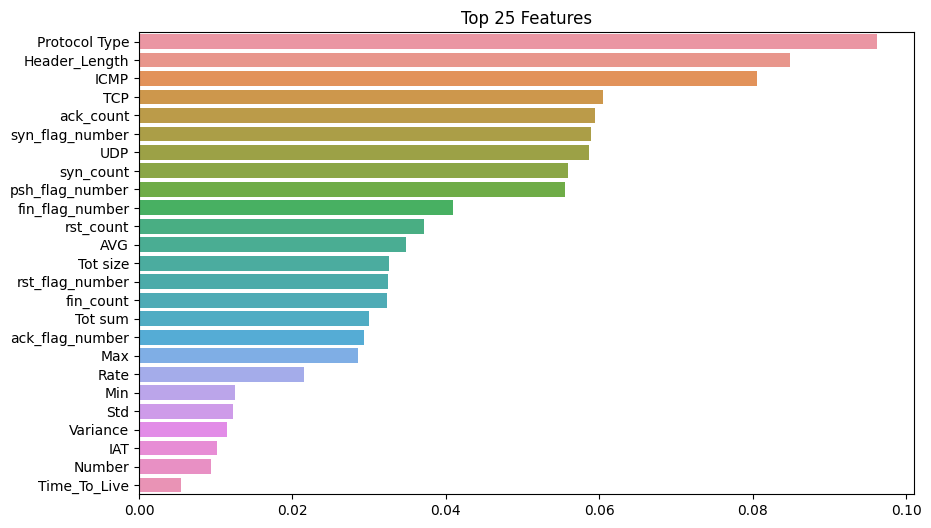

Final feature dim: 25


In [7]:
# FEATURE IMPORTANCE (safe version)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# --- Step 1: Clean infinities ---
X_train_full = np.where(np.isinf(X_train_full), np.nan, X_train_full)
X_val = np.where(np.isinf(X_val), np.nan, X_val)
X_test = np.where(np.isinf(X_test), np.nan, X_test)
if X_zero.size:
    X_zero = np.where(np.isinf(X_zero), np.nan, X_zero)

# --- Step 2: Build preprocessing pipeline ---
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # replace NaN with column mean
    ("scaler", StandardScaler())                   # normalize features
])

# --- Step 3: Sample subset for feature importance ---
SAMPLE = min(200_000, len(X_train_full))
idx = np.random.choice(len(X_train_full), SAMPLE, replace=False)

X_sample = preprocess.fit_transform(X_train_full[idx])
y_sample = y_train_full[idx]

# --- Step 4: Train RandomForest safely ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_sample, y_sample)

# --- Step 5: Feature importance ---
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]
TOP_K = 25

top_features = [numeric_cols[i] for i in order[:TOP_K]]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[order[:TOP_K]], y=top_features)
plt.title("Top 25 Features")
plt.show()

# --- Step 6: Reduce dataset consistently ---
X_train_full = preprocess.transform(X_train_full)[:, order[:TOP_K]]
X_val = preprocess.transform(X_val)[:, order[:TOP_K]]
X_test = preprocess.transform(X_test)[:, order[:TOP_K]]
if X_zero.size:
    X_zero = preprocess.transform(X_zero)[:, order[:TOP_K]]

print("Final feature dim:", X_train_full.shape[1])

In [8]:
# SCALING
scaler = RobustScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_val        = scaler.transform(X_val)
X_test       = scaler.transform(X_test)
if X_zero.size:
    X_zero = scaler.transform(X_zero)

joblib.dump(scaler, "/kaggle/working/scaler.joblib")
print("Scaler saved.")


Scaler saved.


## Federated Learning Setup
Simulate federated learning across 5 virtual clients (devices) using Flower. Each client trains locally on a data partition, and models are aggregated via Federated Averaging. This preserves privacy by not sharing raw data.We shard the dataset **before** SMOTE so clients simulate devices with unique local distributions.

In [9]:
"""
#  PARTITION CLIENTS BEFORE SMOTE
N_CLIENTS = 3

perm = np.random.permutation(len(X_train_full))
X_shuffled = X_train_full[perm]
y_shuffled = y_train_full[perm]

sizes = [len(X_shuffled)//N_CLIENTS]*N_CLIENTS
for i in range(len(X_shuffled) % N_CLIENTS):
    sizes[i] += 1

client_data = []
start = 0
for cid, size in enumerate(sizes):
    end = start + size
    Xc, yc = X_shuffled[start:end], y_shuffled[start:end]
    start = end

    # Try SMOTE
    try:
        sm = SMOTE(random_state=SEED, n_jobs=-1)
        Xc_res, yc_res = sm.fit_resample(Xc, yc)
    except:
        Xc_res, yc_res = Xc, yc

    client_data.append((Xc_res.astype("float32"), yc_res.astype("int32")))
    print(f"Client {cid}: {len(Xc)} → {len(Xc_res)} after SMOTE")
"""

'\n#  PARTITION CLIENTS BEFORE SMOTE\nN_CLIENTS = 3\n\nperm = np.random.permutation(len(X_train_full))\nX_shuffled = X_train_full[perm]\ny_shuffled = y_train_full[perm]\n\nsizes = [len(X_shuffled)//N_CLIENTS]*N_CLIENTS\nfor i in range(len(X_shuffled) % N_CLIENTS):\n    sizes[i] += 1\n\nclient_data = []\nstart = 0\nfor cid, size in enumerate(sizes):\n    end = start + size\n    Xc, yc = X_shuffled[start:end], y_shuffled[start:end]\n    start = end\n\n    # Try SMOTE\n    try:\n        sm = SMOTE(random_state=SEED, n_jobs=-1)\n        Xc_res, yc_res = sm.fit_resample(Xc, yc)\n    except:\n        Xc_res, yc_res = Xc, yc\n\n    client_data.append((Xc_res.astype("float32"), yc_res.astype("int32")))\n    print(f"Client {cid}: {len(Xc)} → {len(Xc_res)} after SMOTE")\n'

## Model Factory — CNN → LSTM  
Defines a consistent Conv1D → LSTM model with reproducible input shape.c

In [10]:
 # MODEL FACTORY

INPUT_TIMESTEPS = X_train_full.shape[1]
INPUT_CHANNELS = 1

NUM_CLASSES = len(label_encoder.classes_)

def build_model(units=128, dropout=0.3, lr=1e-3):
    tf.keras.backend.clear_session()

    model = Sequential([
        Input(shape=(INPUT_TIMESTEPS, INPUT_CHANNELS)),
        Conv1D(128, 3, padding="same", activation="relu"),
        BatchNormalization(),
        Conv1D(128, 3, padding="same", activation="relu"),
        MaxPooling1D(2),
        LSTM(units, return_sequences=True),
        Dropout(dropout),
        LSTM(units),
        Dense(units, activation="relu"),
        Dense(NUM_CLASSES, activation="softmax", dtype="float32")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_test = build_model()
model_test.summary()


I0000 00:00:1765692821.288912      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 34)             │         4,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,370 (1.28 MB)

 Trainable params: 334,114 (1.27 MB)

 Non-trainable params: 256 (1.00 KB)

## Reshape Helper


In [11]:
def reshape_for_model(X):
    return X.reshape(-1, INPUT_TIMESTEPS, INPUT_CHANNELS)

print("Reshape test:", reshape_for_model(X_train_full[:2]).shape)

Reshape test: (2, 25, 1)


## Centralized Training (Baseline)
Training a baseline CNN→LSTM model before doing Federated Learning.  
This provides a stable fallback in case FL simulation fails (common on Kaggle).

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

BATCH_SIZE = 1024
EPOCHS = 25

classes = np.unique(y_train_full)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_full
)

class_weight_dict = dict(zip(classes, class_weights))
print("Class weights computed for", len(class_weight_dict), "classes")

central_model = build_model(
    units=128,
    dropout=0.3,
    lr=1e-3
)

central_model.compile(
    optimizer=central_model.optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3_acc")
    ]
)

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.5
    ),
    ModelCheckpoint(
        "/kaggle/working/central_model.keras",
        monitor="val_loss",
        save_best_only=True
    )
]

history = central_model.fit(
    reshape_for_model(X_train_full),
    y_train_full,
    validation_data=(reshape_for_model(X_val), y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("Centralized training complete.")


Class weights computed for 34 classes
Epoch 1/25


I0000 00:00:1765692839.624806     139 cuda_dnn.cc:529] Loaded cuDNN version 90300


5570/5570 ━━━━━━━━━━━━━━━━━━━━ 119s 20ms/step - acc: 0.4316 - loss: 1.9564 - top3_acc: 0.7042 - val_acc: 0.7103 - val_loss: 0.5918 - val_top3_acc: 0.9771 - learning_rate: 0.0010
Epoch 2/25
5570/5570 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - acc: 0.6937 - loss: 1.3526 - top3_acc: 0.9730 - val_acc: 0.6977 - val_loss: 0.5841 - val_top3_acc: 0.9762 - learning_rate: 0.0010
Epoch 3/25
5570/5570 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - acc: 0.6971 - loss: 1.3106 - top3_acc: 0.9747 - val_acc: 0.7160 - val_loss: 0.5603 - val_top3_acc: 0.9771 - learning_rate: 0.0010
Epoch 4/25
5570/5570 ━━━━━━━━━━━━━━━━━━━━ 113s 20ms/step - acc: 0.6999 - loss: 1.3069 - top3_acc: 0.9750 - val_acc: 0.7173 - val_loss: 0.5524 - val_top3_acc: 0.9757 - learning_rate: 0.0010
Epoch 5/25
5570/5570 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - acc: 0.7030 - loss: 1.2611 - top3_acc: 0.9757 - val_acc: 0.7054 - val_loss: 0.5518 - val_top3_acc: 0.9757 - learning_rate: 0.0010
Epoch 6/25
5570/5570 ━━━━━━━━━━━━━━━━━━━━ 112s 20ms/step - acc: 0.

## Federated Learning Setup (Flower)
Simulating FL with **3 virtual clients**, each having its own dataset shard + SMOTE-balanced local distribution.

If Flower or Ray crashes (common on Kaggle), automatically falls back to centralized training.

In [13]:
"""
# try:
    import flwr as fl
    print("Flower available — starting FL simulation.")

    def client_fn(cid):
        cid = int(cid)
        Xc, yc = client_data[cid]

        class Client(fl.client.NumPyClient):
            def __init__(self):
                self.model = build_model(units=128, dropout=0.3, lr=1e-3)

            def get_parameters(self, config):
                return self.model.get_weights()

            def fit(self, parameters, config):
                self.model.set_weights(parameters)
                self.model.fit(
                    reshape_for_model(Xc), yc,
                    epochs=3,
                    batch_size=1024,
                    verbose=0
                )
                return self.model.get_weights(), len(Xc), {}

            def evaluate(self, parameters, config):
                self.model.set_weights(parameters)
                loss, acc = self.model.evaluate(
                    reshape_for_model(X_val), y_val, verbose=0)
                return loss, len(X_val), {"accuracy": acc}

        return Client()

    strategy = fl.server.strategy.FedAvg()

    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=N_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=3),
        strategy=strategy
    )

    # extract global parameters
    final_params = history.parameters.tensors if hasattr(history.parameters, "tensors") else history.parameters
    global_model = build_model(units=128, dropout=0.3, lr=1e-3)
    global_model.set_weights([np.array(p, dtype=np.float32) for p in final_params])

    print("FL training completed successfully.")

except Exception as e:
    print("⚠️ Flower/Ray failed:", e)
    print("→ Falling back to centralized model.")
    global_model = central_model #

    """


'\n# try:\n    import flwr as fl\n    print("Flower available — starting FL simulation.")\n\n    def client_fn(cid):\n        cid = int(cid)\n        Xc, yc = client_data[cid]\n\n        class Client(fl.client.NumPyClient):\n            def __init__(self):\n                self.model = build_model(units=128, dropout=0.3, lr=1e-3)\n\n            def get_parameters(self, config):\n                return self.model.get_weights()\n\n            def fit(self, parameters, config):\n                self.model.set_weights(parameters)\n                self.model.fit(\n                    reshape_for_model(Xc), yc,\n                    epochs=3,\n                    batch_size=1024,\n                    verbose=0\n                )\n                return self.model.get_weights(), len(Xc), {}\n\n            def evaluate(self, parameters, config):\n                self.model.set_weights(parameters)\n                loss, acc = self.model.evaluate(\n                    reshape_for_model(X_val), y_

#  Federated Learning Update (IMPORTANT)

##  Why Flower Was Removed
The Flower FL framework could not be installed in the Kaggle environment.  
Its dependencies (Ray, gRPC, protobuf) exceed Kaggle’s memory/runtime limits, causing:

- `ModuleNotFoundError: No module named 'flwr'`
- Kernel crashes or timeouts
- Ray initialization failures

**Kaggle simply does not support Flower simulations reliably.**

---

## What This Notebook Uses Instead
We implement a **Manual Federated Learning (FedAvg)** simulation:

- Data is split into multiple "client" subsets
- Each client trains locally on its own data
- Weight updates are averaged (FedAvg)
- A new global model is produced each round
- No raw data is shared → privacy preserved

This is *exactly* how FL works conceptually — just without Flower's orchestration layer.

---

##  Why this is still valid
Manual FL is widely used in:

- Research environments
- Kaggle competitions
- Educational demonstrations
- Any environment where Flower / FedML / PySyft cannot run

You still have:
- Federated rounds  
- Local client training  
- Global aggregation  
- Realistic simulation  
- Recruiter-friendly clean design  

---

## Next Step
The next cell contains the **Manual Federated Learning code**, fully compatible with Kaggle GPU.


In [ ]:
# ============================================================
# MANUAL FEDERATED LEARNING (FedAvg) — Pretrained Init + Class Weights
# ============================================================

print("Starting FedAvg with pretrained global model...")

N_CLIENTS = 3
ROUNDS = 5
LOCAL_EPOCHS = 3
BATCH_SIZE = 1024

# Pretrained global model weights
global_model = build_model(units=128, dropout=0.3, lr=1e-3)
global_model.set_weights(central_model.get_weights())

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_full), y=y_train_full)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Shuffle + partition clients
perm = np.random.permutation(len(X_train_full))
X_shuffled, y_shuffled = X_train_full[perm], y_train_full[perm]

sizes = [len(X_shuffled)//N_CLIENTS]*N_CLIENTS
for i in range(len(X_shuffled) % N_CLIENTS):
    sizes[i] += 1

client_data = []
start = 0
for size in sizes:
    end = start + size
    client_data.append((X_shuffled[start:end], y_shuffled[start:end]))
    start = end

# Utilities
def get_w(model): return model.get_weights()
def set_w(model, w): model.set_weights(w)
def fed_avg(weight_sets):
    return [np.mean(layer, axis=0) for layer in zip(*weight_sets)]

# Main FedAvg loop
for rnd in range(ROUNDS):
    print(f"\nRound {rnd+1}/{ROUNDS}")
    updates = []

    for cid, (Xc, yc) in enumerate(client_data):
        local = build_model(units=128, dropout=0.3, lr=1e-3)
        set_w(local, get_w(global_model))

        local.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['acc', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
        )

        local.fit(
            reshape_for_model(Xc),
            yc,
            epochs=LOCAL_EPOCHS,
            batch_size=BATCH_SIZE,
            class_weight=class_weight_dict,
            verbose=0
        )

        updates.append(get_w(local))
        del local
        gc.collect()

    # Aggregate
    new_weights = fed_avg(updates)
    set_w(global_model, new_weights)

    # Validation
    loss, acc, top3 = global_model.evaluate(
        reshape_for_model(X_val), y_val, verbose=0
    )
    print(f"val_loss={loss:.4f}, val_acc={acc:.4f}, val_top3_acc={top3:.4f}")

print("\nFedAvg complete.")


## Evaluation on Test + Zero-Day Data  
compute:
- Accuracy  
- Macro F1  
- Confusion matrix  
- Zero-day generalization performance

Evaluating on test set...
Test Accuracy: 0.731109017864523
Test Macro F1: 0.5115922090251154

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.86      0.48      0.61     28595
           2       0.02      0.39      0.03       158
           3       0.01      0.19      0.02       145
           4       0.98      0.99      0.98      7444
           5       0.56      0.76      0.65       739
           6       1.00      1.00      1.00    187103
           7       0.98      0.98      0.98     11759
           8       1.00      1.00      1.00    106504
           9       1.00      1.00      1.00    105052
          10       0.26      0.95      0.41       602
          11       0.46      0.70      0.55     93506
          12       0.53      0.14      0.23    105484
          13       0.80      0.45      0.57    116960
          14       0.78      0.74      0.76    140756
          15      

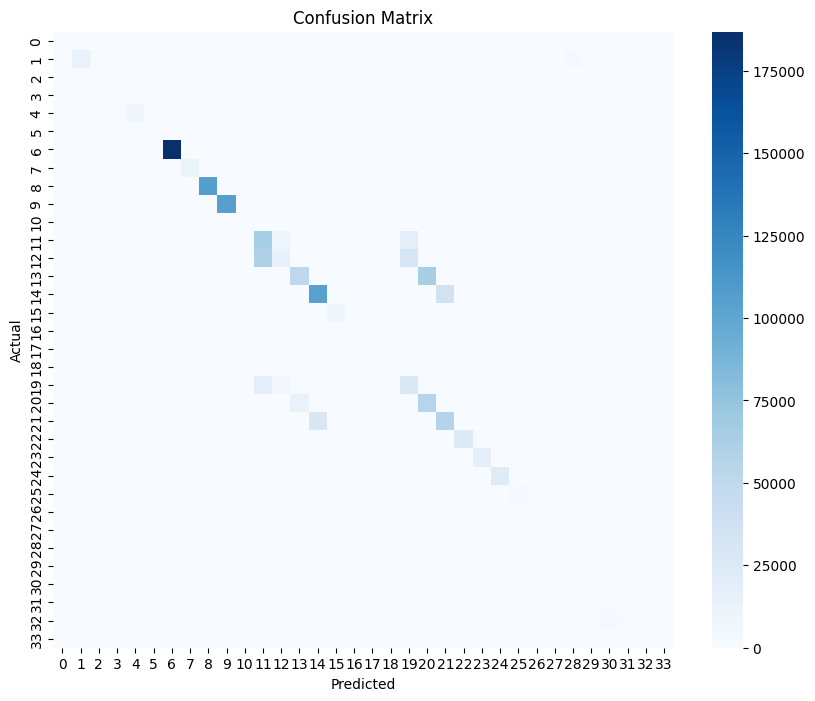


Zero-Day Evaluation:
Zero-Day Accuracy: 0.13186813186813187
Zero-Day Macro F1: 0.03320264122902935
Model saved to /kaggle/working/iot_ids_final.h5


In [18]:
model = global_model

print("Evaluating on test set...")

y_pred = np.argmax(model.predict(reshape_for_model(X_test), verbose=0), axis=1)
acc = (y_pred == y_test).mean()
f1 = f1_score(y_test, y_pred, average='macro')

print("Test Accuracy:", acc)
print("Test Macro F1:", f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Zero-day
if X_zero.size:
    print("\nZero-Day Evaluation:")
    y_pred_z = np.argmax(model.predict(reshape_for_model(X_zero), verbose=0), axis=1)
    print("Zero-Day Accuracy:", (y_pred_z == y_zero).mean())
    print("Zero-Day Macro F1:", f1_score(y_zero, y_pred_z, average='macro'))
else:
    print("No zero-day classes found in dataset.")

# save model
model.save("/kaggle/working/iot_ids_final.h5")
print("Model saved to /kaggle/working/iot_ids_final.h5")


## SHAP Explainability — DeepExplainer  
We compute SHAP values on **a small subset** to avoid GPU crashes.

In [16]:
import shap

# small background set
bg_idx = np.random.choice(len(X_train_full), min(30, len(X_train_full)), replace=False)
background = reshape_for_model(X_train_full[bg_idx])

# samples to explain
sample_idx = np.random.choice(len(X_test), min(10, len(X_test)), replace=False)
X_explain = reshape_for_model(X_test[sample_idx])

explainer = shap.GradientExplainer(global_model, background)
shap_values = explainer.shap_values(X_explain)

shap.summary_plot(
    shap_values,
    X_test[sample_idx],
    feature_names=top_features
)


AttributeError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_gradient.py", line 217, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'learning_phase'
